In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
learning_rate = 0.5
epochs = 10
batch_size = 100
# declare the training data placeholders
# input x - for 28 x 28 pixels = 784
x = tf.placeholder(tf.float32, [None, 784])
# now declare the output data placeholder - 10 digits
y = tf.placeholder(tf.float32, [None, 10])

In [5]:
# now declare the weights connecting the input to the hidden layer
W1 = tf.Variable(tf.random_normal([784, 300], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([300]), name='b1')
# and the weights connecting the hidden layer to the output layer
W2 = tf.Variable(tf.random_normal([300, 10], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([10]), name='b2')

In [6]:
# calculate the output of the hidden layer
hidden_out = tf.add(tf.matmul(x, W1), b1)
hidden_out = tf.nn.relu(hidden_out)

In [7]:
# now calculate the hidden layer output - in this case, let's use a softmax activated
# output layer
y_ = tf.nn.softmax(tf.add(tf.matmul(hidden_out, W2), b2))
confusion_matrix_tf = tf.confusion_matrix(tf.argmax(y, 1), tf.argmax(y_, 1))

In [8]:
y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)
                         + (1 - y) * tf.log(1 - y_clipped), axis=1))

In [9]:
# add an optimiser
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

In [10]:
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [11]:
cm = tf.zeros(shape=[10,10], dtype=tf.int32)
# start the session
with tf.Session() as sess:
    # initialise the variables
    sess.run(init_op)
    avg_cost = []
    accur_list=[]
    total_batch = int(len(mnist.train.labels) / batch_size)
    for epoch in range(epochs):
        avg_cost.append(0)
        accur_list.append(0)
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
            c = sess.run([optimiser, cross_entropy], 
                         feed_dict={x: batch_x, y: batch_y})
            avg_cost[epoch] += c[1] / total_batch
        accur_list[epoch]=sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels})
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost[epoch]))

    _acc=sess.run([accuracy], feed_dict={x: mnist.test.images, y: mnist.test.labels})
    cls_pred = sess.run(y_, feed_dict={x: mnist.test.images, y: mnist.test.labels})
    cm = confusion_matrix_tf.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels})
    
    print(cm)
    
    TP = np.diag(cm)
    FP = np.sum(cm, axis=0) - TP
    FN = np.sum(cm, axis=1) - TP
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F = 2* (precision*recall)/(precision+recall)
    print(F)

Epoch: 1 cost = 0.582
Epoch: 2 cost = 0.208
Epoch: 3 cost = 0.148
Epoch: 4 cost = 0.116
Epoch: 5 cost = 0.093
Epoch: 6 cost = 0.075
Epoch: 7 cost = 0.061
Epoch: 8 cost = 0.049
Epoch: 9 cost = 0.038
Epoch: 10 cost = 0.032
[[ 971    1    1    1    2    0    0    1    2    1]
 [   0 1127    3    1    0    0    0    1    3    0]
 [   1    1 1015    2    2    0    0    6    5    0]
 [   0    0    4  990    1    2    0    5    3    5]
 [   0    0    5    1  956    0    2    3    1   14]
 [   2    0    0    9    1  871    2    0    5    2]
 [   6    3    1    1   10    9  921    0    7    0]
 [   1    1    5    2    0    0    0 1014    2    3]
 [   0    1    2    5    1    1    1    2  958    3]
 [   1    3    0    5    8    4    0    9    1  978]]
[0.98980632 0.99207746 0.98162476 0.97681302 0.97401936 0.9792018
 0.97770701 0.98018366 0.97705252 0.9707196 ]


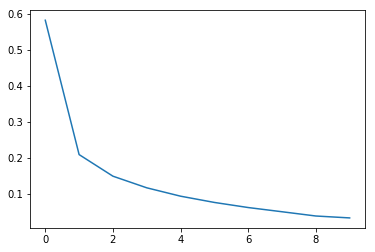

In [12]:
plt.plot(range(epochs), avg_cost)
plt.show()

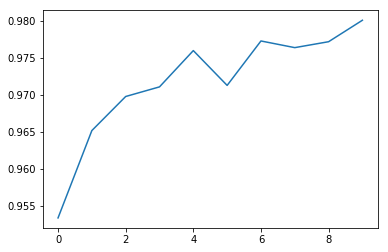

In [13]:
plt.plot(range(epochs), accur_list)
plt.show()

In [14]:
np.save('fscore_mnist.npy',F)
np.save('confusion_mnist.npy', cm)